In [2]:
import os, sys

In [3]:
%matplotlib inline
import sys
import errno
import pandas as pd
import numpy as np
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
from matplotlib import figure
from scipy.cluster.hierarchy import fcluster
from statsmodels.graphics.tsaplots import plot_pacf
from collections import OrderedDict
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

In [6]:
plt.rcParams['figure.figsize'] = [11,6]

In [7]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='USDT_BTC', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query,verify=False)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [8]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [9]:
def get_pairs():
    for pair in ['USDT_BTC','USDT_ETH', 'USDT_LTC', 'USDT_DASH', 'BTC_ETH', 'BTC_LTC', 'BTC_DASH']:
        timeSeries = pd.DataFrame()
        df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
        df = df[df.index % 7 == 0]
        df['pct_change'] = df['weightedAverage'].pct_change()
        df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
        df[pair] = df['log_ret']
        df = pd.DataFrame(df[pair])
        timeSeries = pd.concat([timeSeries,df], axis=1)
        timeSeries = timeSeries.iloc[1:]
        yield timeSeries, pair

In [10]:
def generate_clusters(timeSeries, pair):
    z_euclidean = hac.linkage(timeSeries, method='average', metric='euclidean'),"Euclidean"
    z_minkowski = hac.linkage(timeSeries, method='average', metric='minkowski'),"Minowski"
    z_cityblock = hac.linkage(timeSeries, method='average', metric='cityblock'),"Cityblock"
    z_cosine = hac.linkage(timeSeries, method='average', metric='cosine'),"Cosine"
#    z_correlation = hac.linkage(timeSeries, method='average', metric='correlation'),"Correlation"

    p = 12
    max_d = 50
    
    for z, name in [z_euclidean,z_minkowski,z_cityblock,z_cosine]:#,z_correlation]: 
                                #ValueError: Method 'ward' requires the distance metric to be Euclidean
        print(pair)
        print(name, "/", "Avg")
        fancy_dendrogram(
            z,
            truncate_mode='lastp',
            p=p,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            annotate_above=10,  # useful in small plots so annotations don't overlap
            max_d=max_d,
        )
        plt.show()
        
        c, coph_dists = cophenet(z, pdist(timeSeries))
        print(name + " Cophenetic Correlation Coefficient: " + str(c))

        print("Euclidean Clusters")
        clusters = fcluster(z, max_d, criterion='distance')
#         plt.figure(figsize=(10, 8))
        ar = np.arange(len(timeSeries))
        plt.scatter(timeSeries[pair], timeSeries[pair], c=clusters, cmap='prism')  # plot points with cluster dependent colors
        plt.show()

In [11]:
def plot_partial_lag(timeSeries, lag):
    plot_pacf(timeSeries, lags=lag)
    plt.show()    

USDT_BTC
Euclidean / Avg


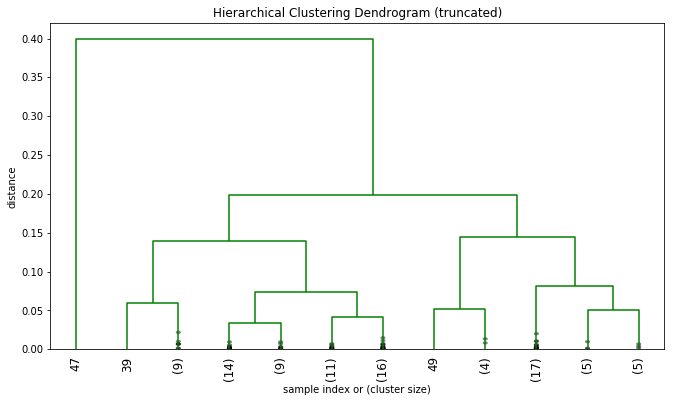

Euclidean Cophenetic Correlation Coefficient: 0.7527205098861712
Euclidean Clusters


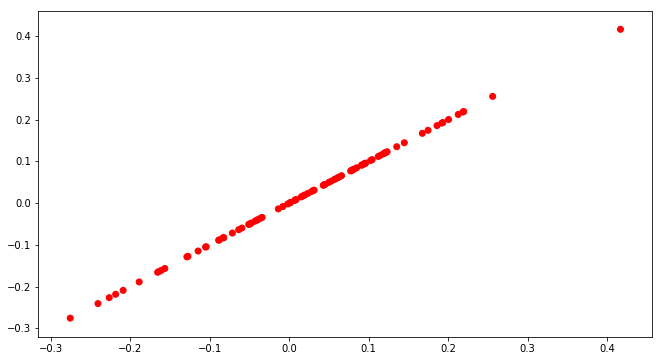

USDT_BTC
Minowski / Avg


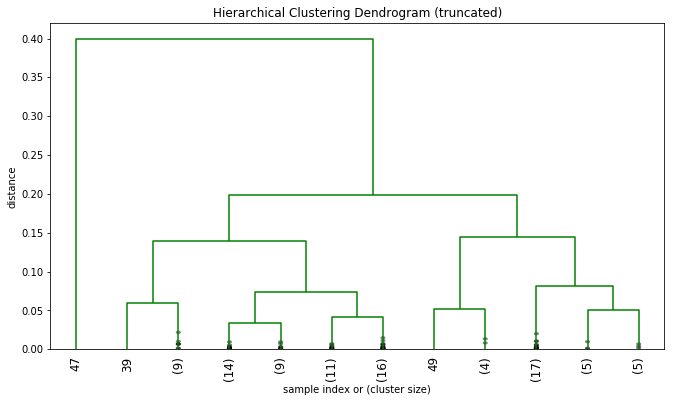

Minowski Cophenetic Correlation Coefficient: 0.7527205098861712
Euclidean Clusters


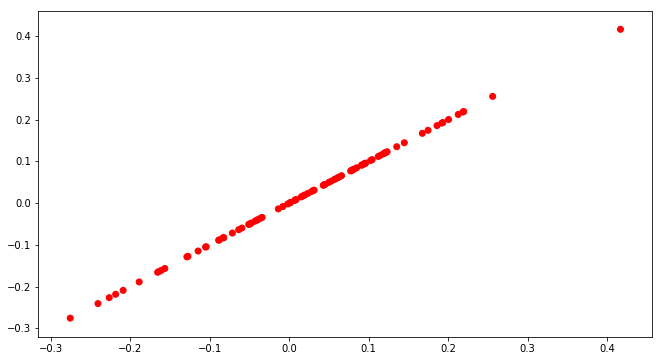

USDT_BTC
Cityblock / Avg


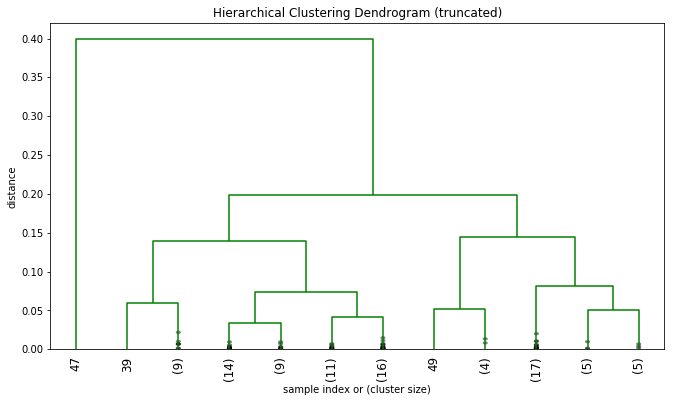

Cityblock Cophenetic Correlation Coefficient: 0.7527205098861712
Euclidean Clusters


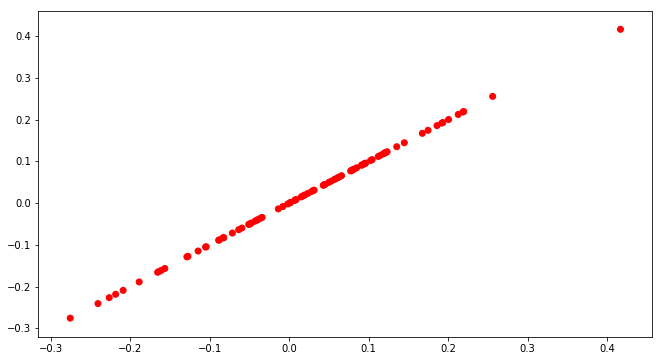

USDT_BTC
Cosine / Avg


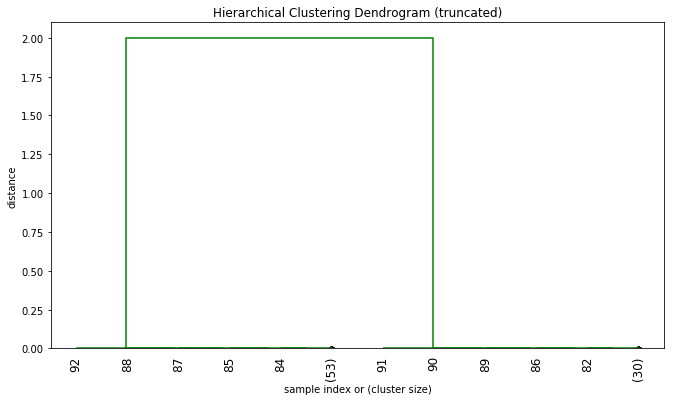

Cosine Cophenetic Correlation Coefficient: 0.5603750169577935
Euclidean Clusters


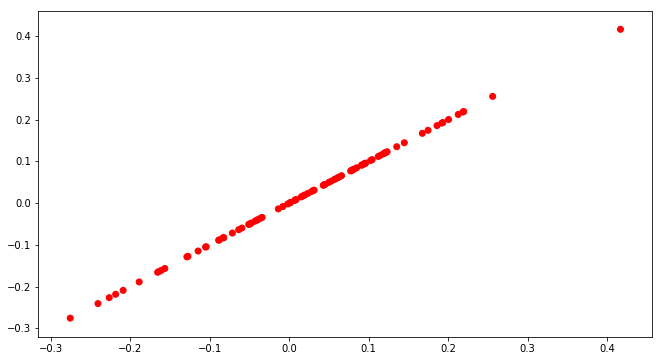

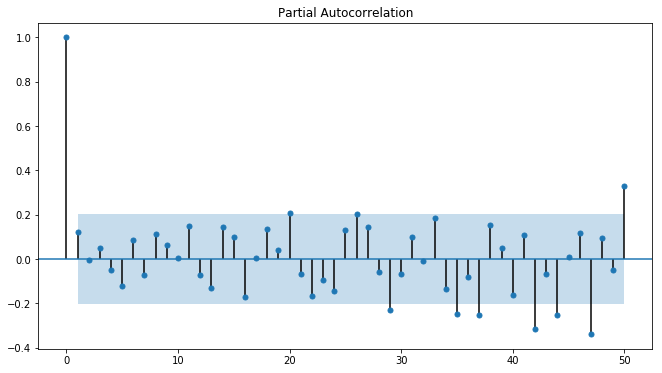

USDT_ETH
Euclidean / Avg


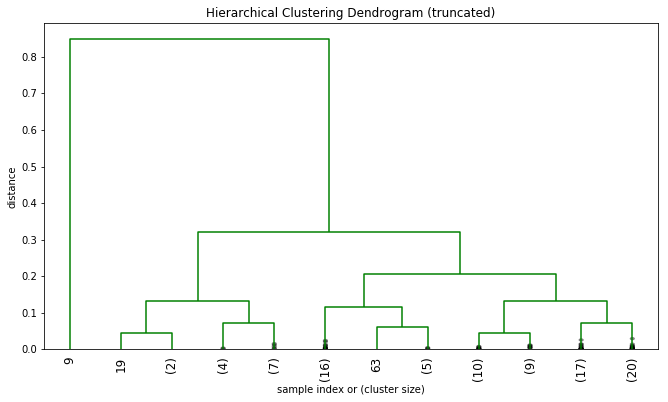

Euclidean Cophenetic Correlation Coefficient: 0.8460942437533073
Euclidean Clusters


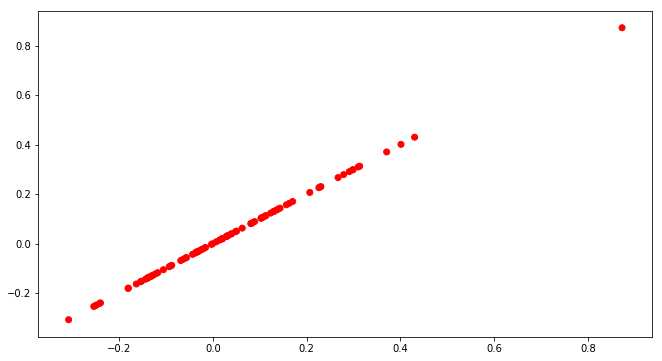

USDT_ETH
Minowski / Avg


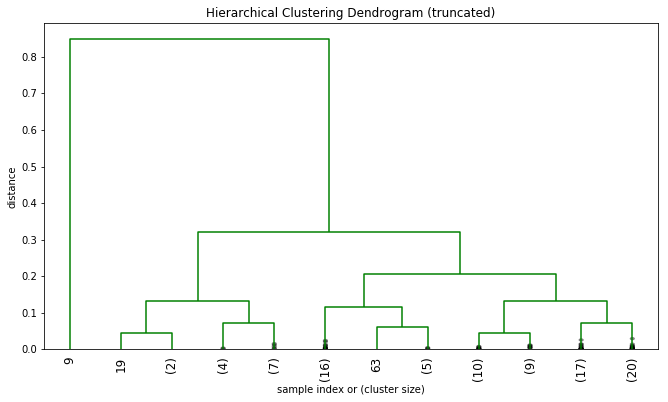

Minowski Cophenetic Correlation Coefficient: 0.8460942437533073
Euclidean Clusters


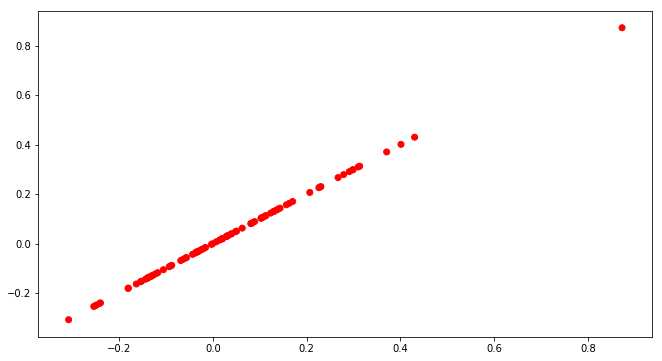

USDT_ETH
Cityblock / Avg


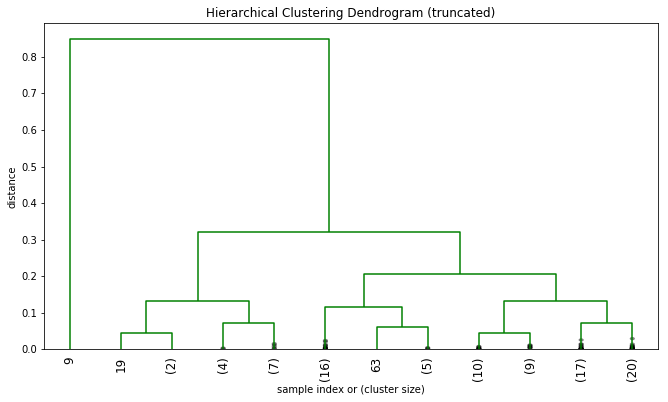

Cityblock Cophenetic Correlation Coefficient: 0.8460942437533073
Euclidean Clusters


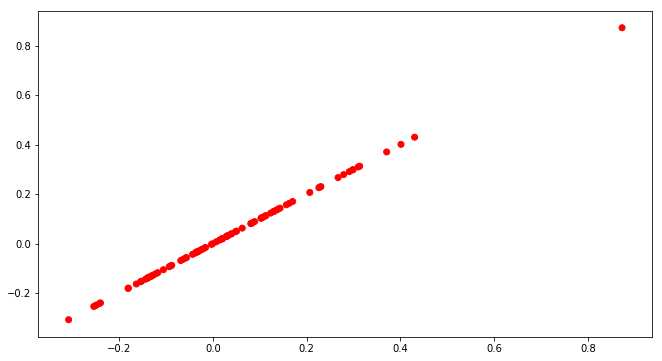

USDT_ETH
Cosine / Avg


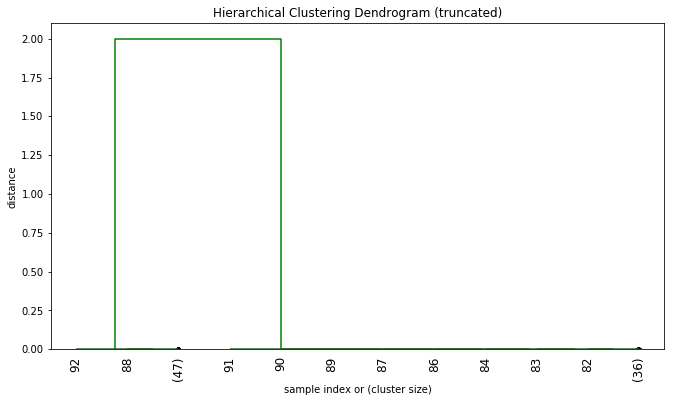

Cosine Cophenetic Correlation Coefficient: 0.42530243500365356
Euclidean Clusters


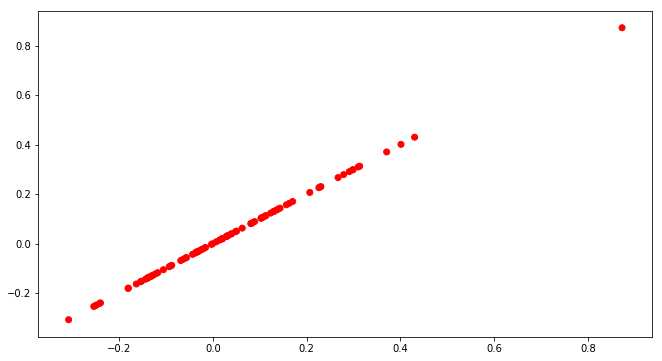

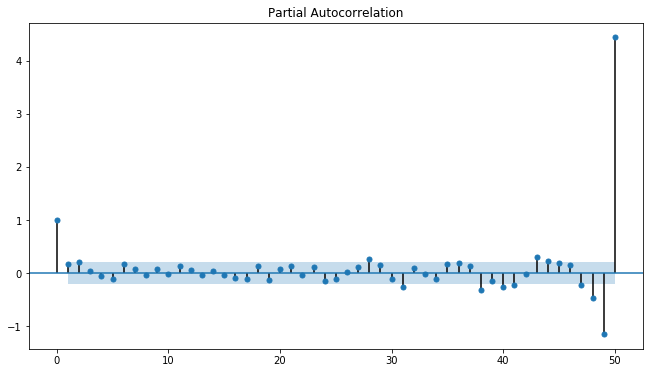

USDT_LTC
Euclidean / Avg


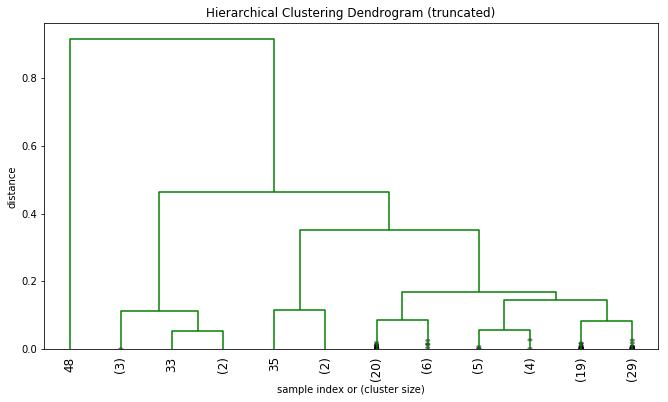

Euclidean Cophenetic Correlation Coefficient: 0.9084339045940071
Euclidean Clusters


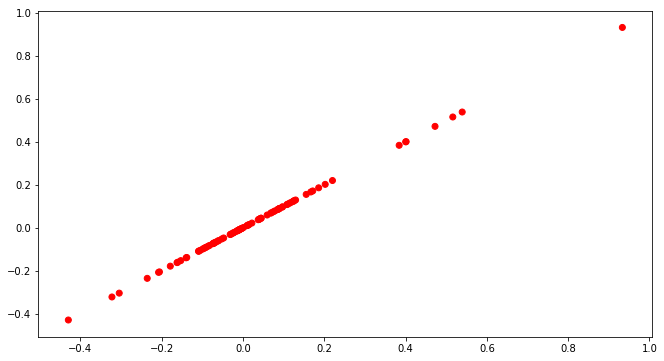

USDT_LTC
Minowski / Avg


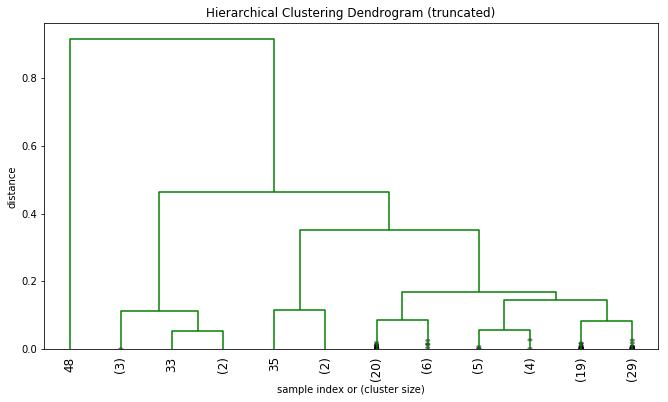

Minowski Cophenetic Correlation Coefficient: 0.9084339045940071
Euclidean Clusters


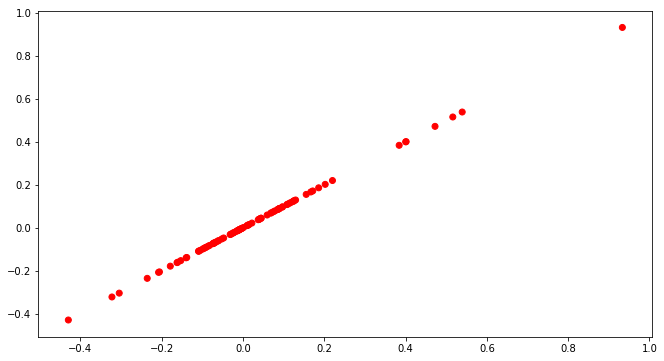

USDT_LTC
Cityblock / Avg


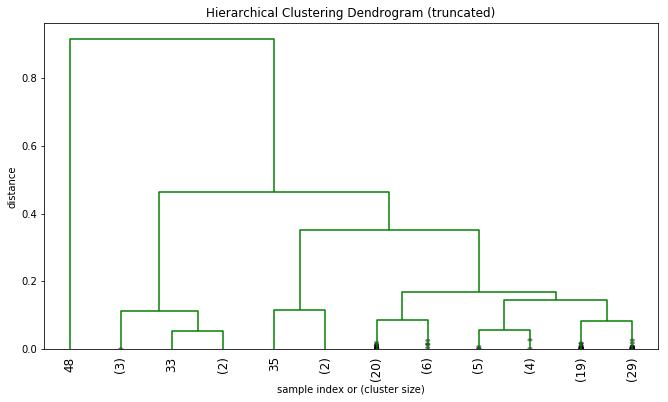

Cityblock Cophenetic Correlation Coefficient: 0.9084339045940071
Euclidean Clusters


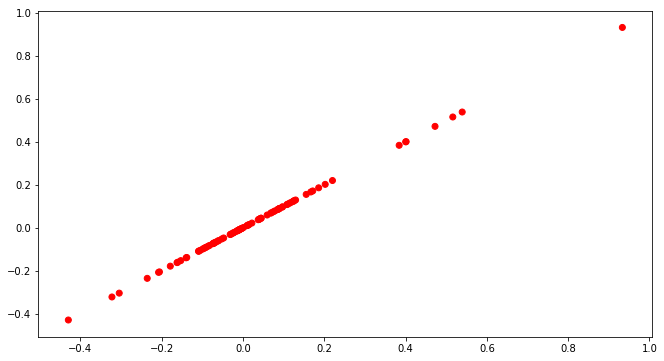

USDT_LTC
Cosine / Avg


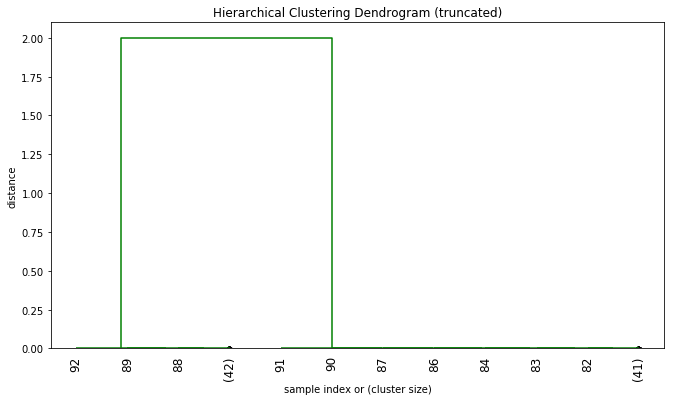

Cosine Cophenetic Correlation Coefficient: 0.31719270756179413
Euclidean Clusters


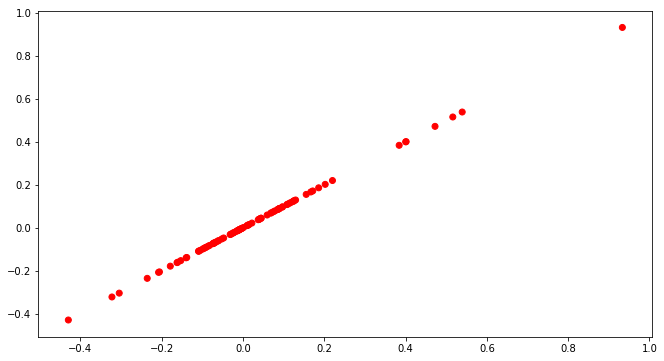

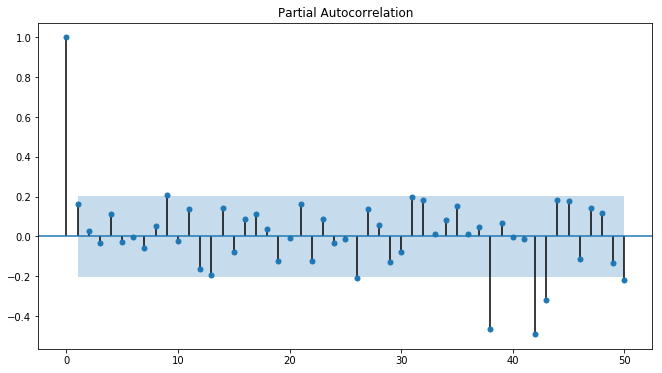

USDT_DASH
Euclidean / Avg


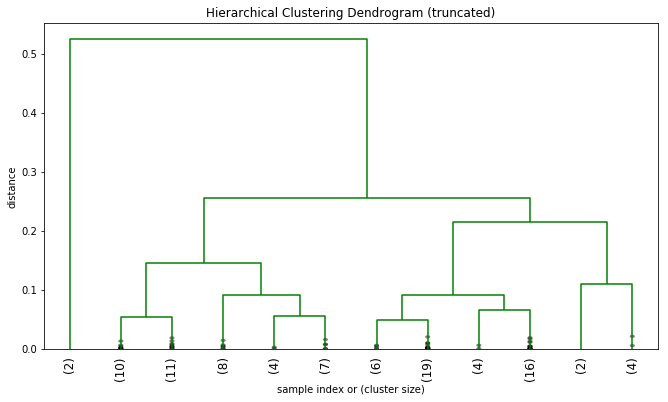

Euclidean Cophenetic Correlation Coefficient: 0.7664700849624559
Euclidean Clusters


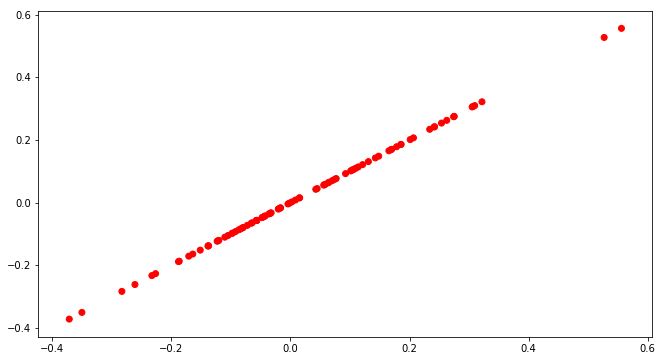

USDT_DASH
Minowski / Avg


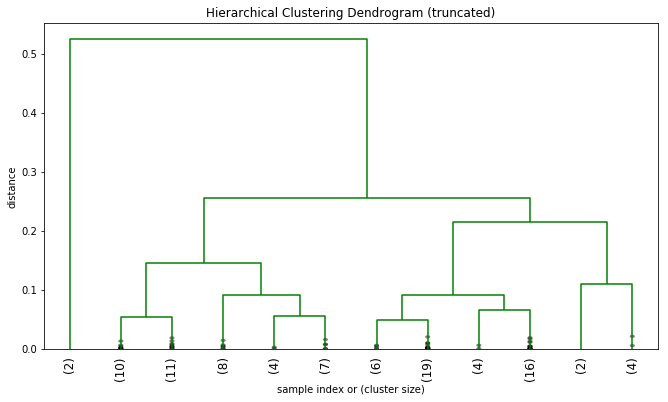

Minowski Cophenetic Correlation Coefficient: 0.7664700849624559
Euclidean Clusters


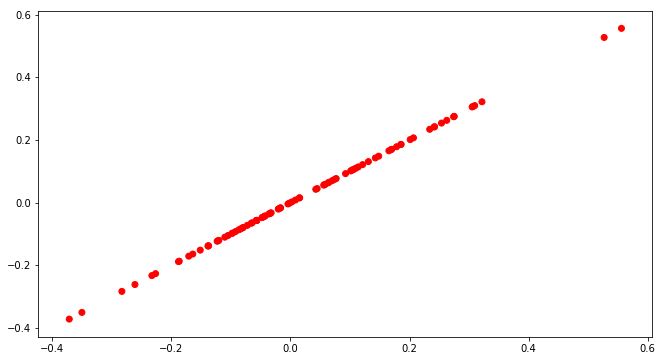

USDT_DASH
Cityblock / Avg


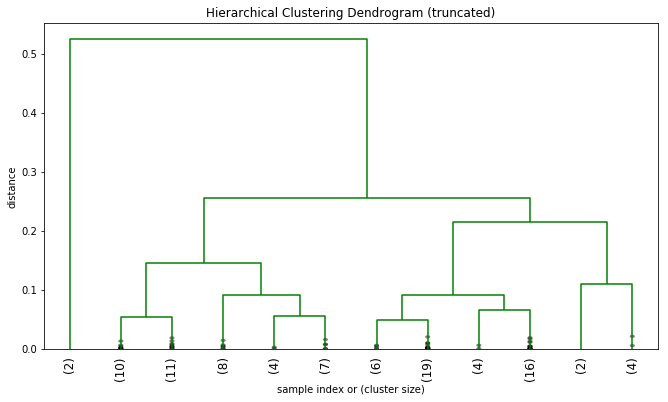

Cityblock Cophenetic Correlation Coefficient: 0.7664700849624559
Euclidean Clusters


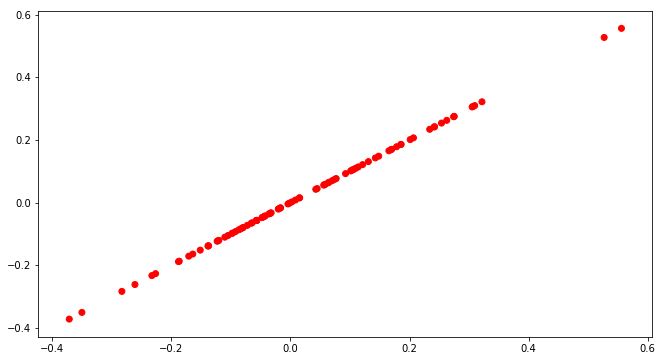

USDT_DASH
Cosine / Avg


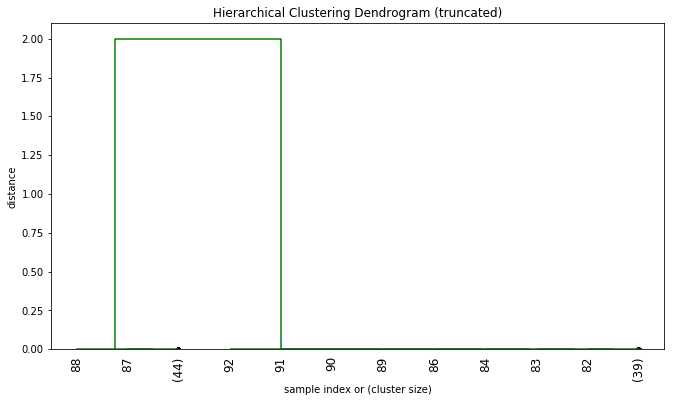

Cosine Cophenetic Correlation Coefficient: 0.5320913446244276
Euclidean Clusters


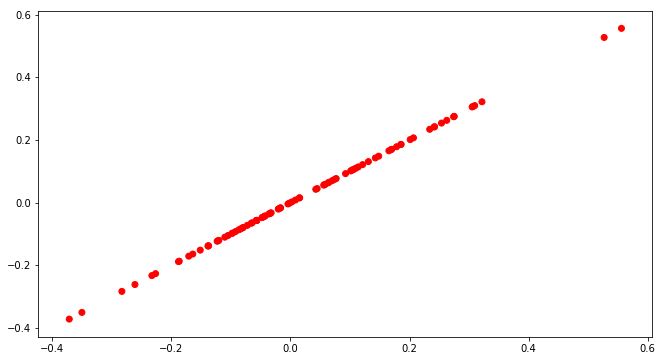

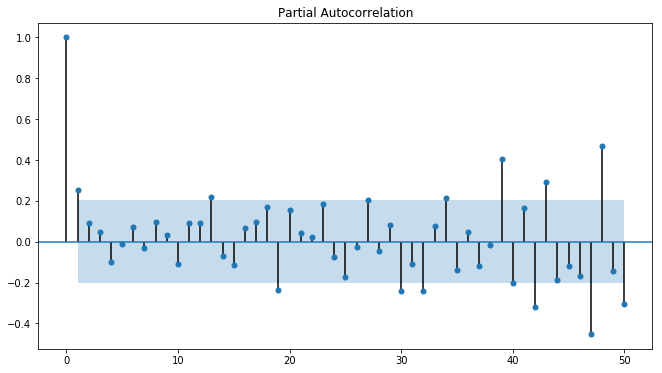

BTC_ETH
Euclidean / Avg


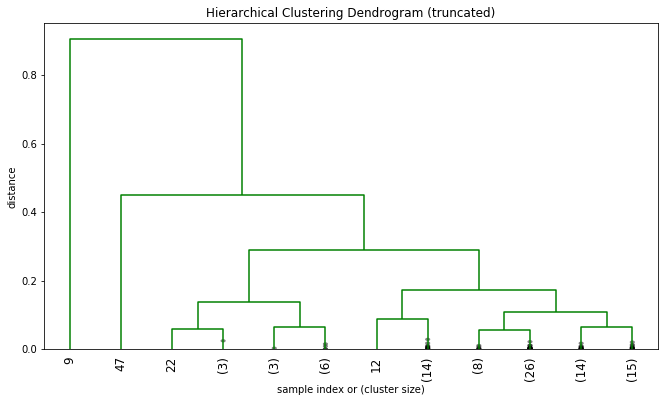

Euclidean Cophenetic Correlation Coefficient: 0.8931614123780455
Euclidean Clusters


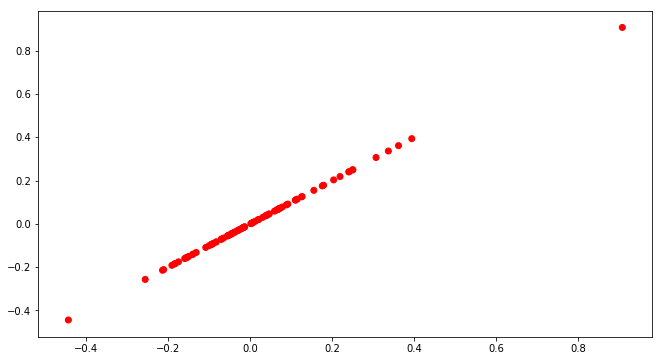

BTC_ETH
Minowski / Avg


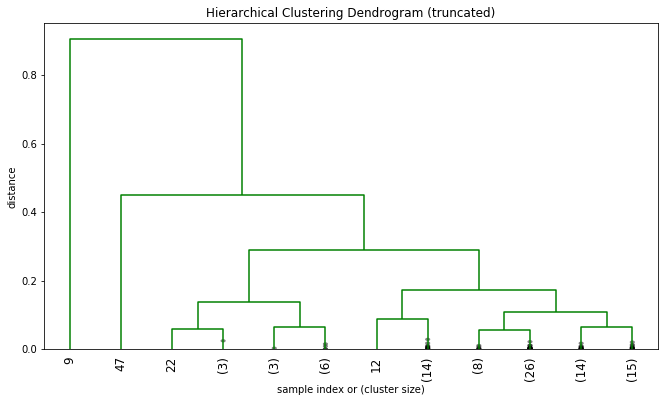

Minowski Cophenetic Correlation Coefficient: 0.8931614123780455
Euclidean Clusters


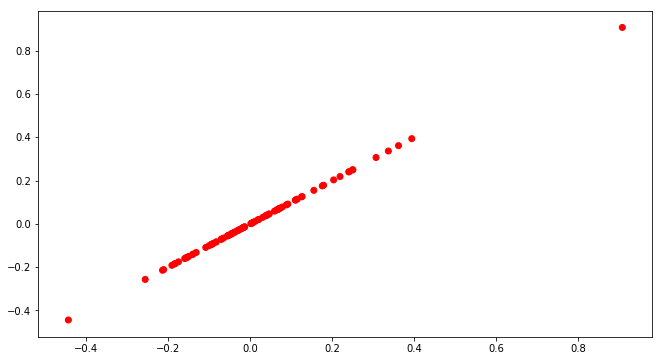

BTC_ETH
Cityblock / Avg


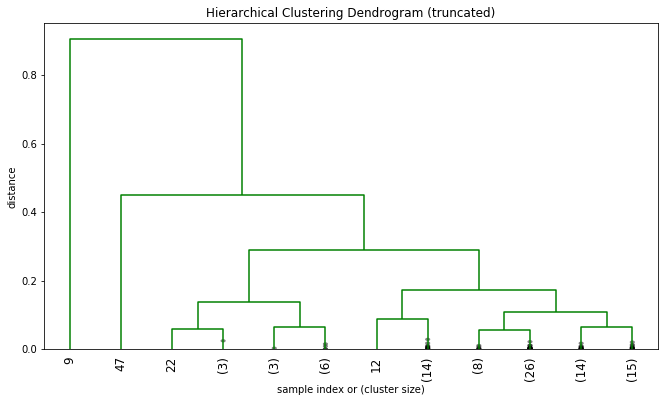

Cityblock Cophenetic Correlation Coefficient: 0.8931614123780455
Euclidean Clusters


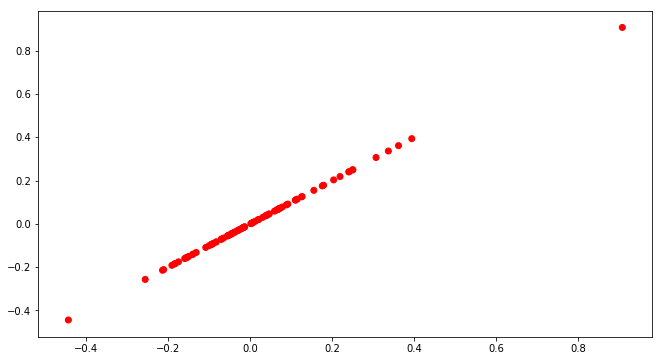

BTC_ETH
Cosine / Avg


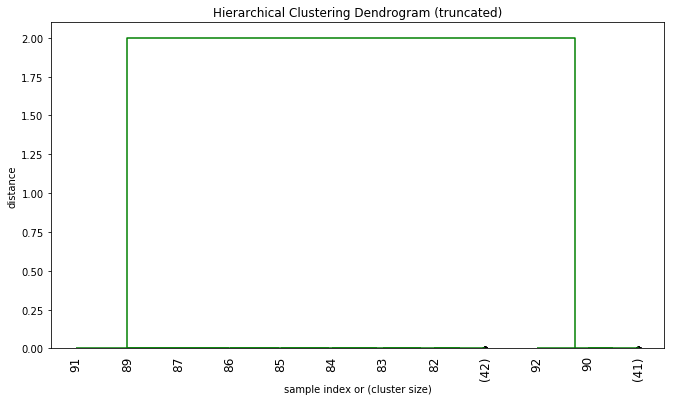

Cosine Cophenetic Correlation Coefficient: 0.3628112438409152
Euclidean Clusters


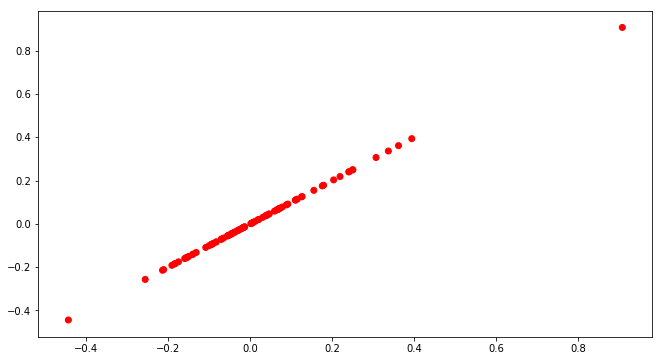

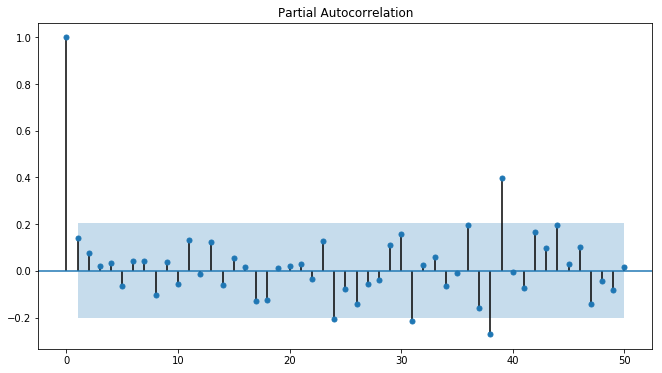

BTC_LTC
Euclidean / Avg


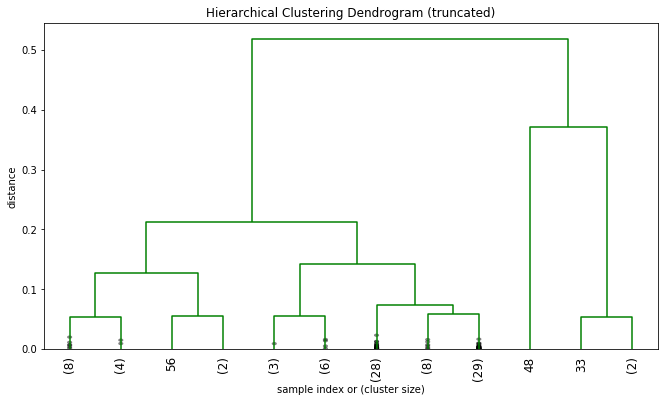

Euclidean Cophenetic Correlation Coefficient: 0.8680107254265719
Euclidean Clusters


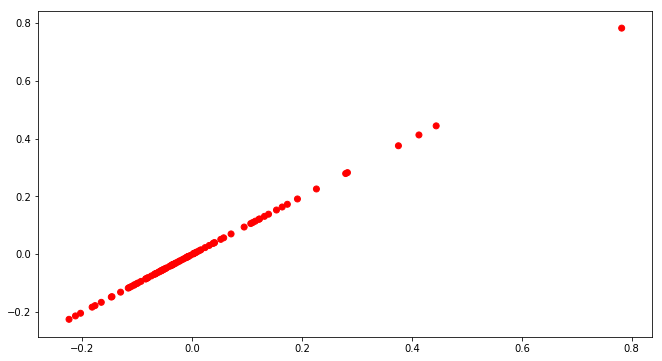

BTC_LTC
Minowski / Avg


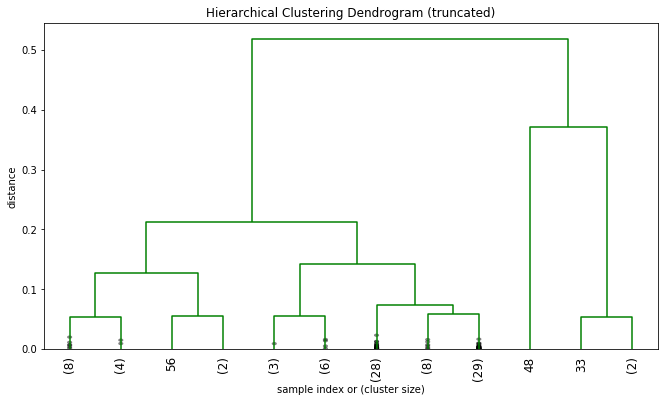

Minowski Cophenetic Correlation Coefficient: 0.8680107254265719
Euclidean Clusters


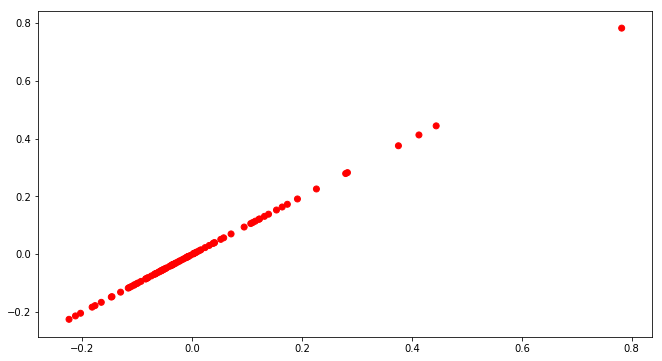

BTC_LTC
Cityblock / Avg


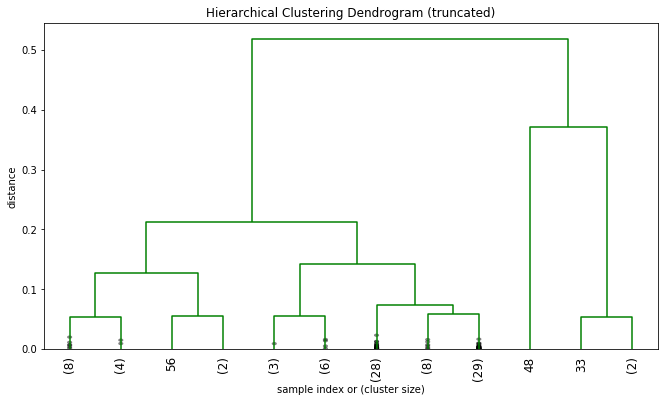

Cityblock Cophenetic Correlation Coefficient: 0.8680107254265719
Euclidean Clusters


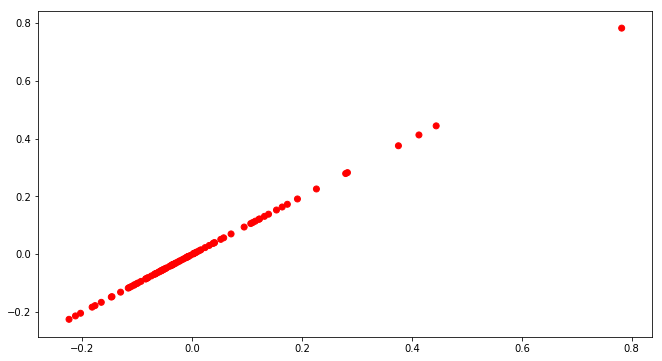

BTC_LTC
Cosine / Avg


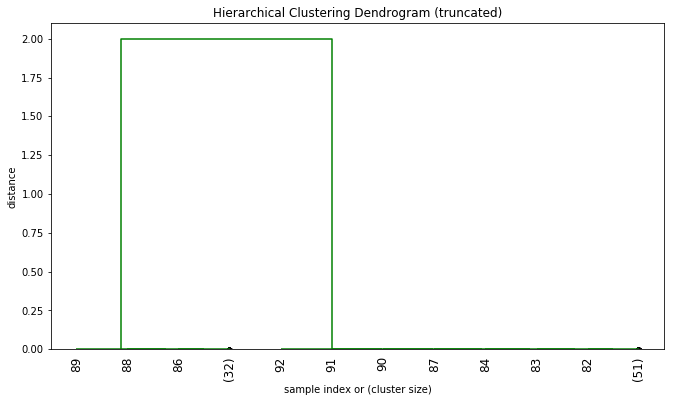

Cosine Cophenetic Correlation Coefficient: 0.40371678070047773
Euclidean Clusters


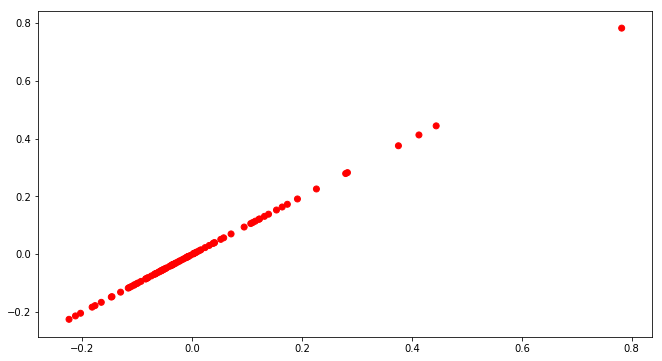

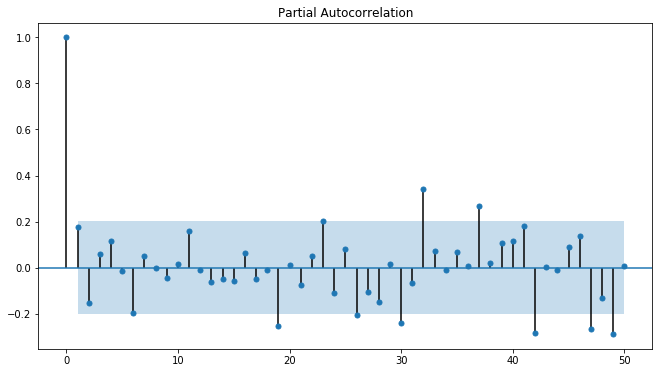

BTC_DASH
Euclidean / Avg


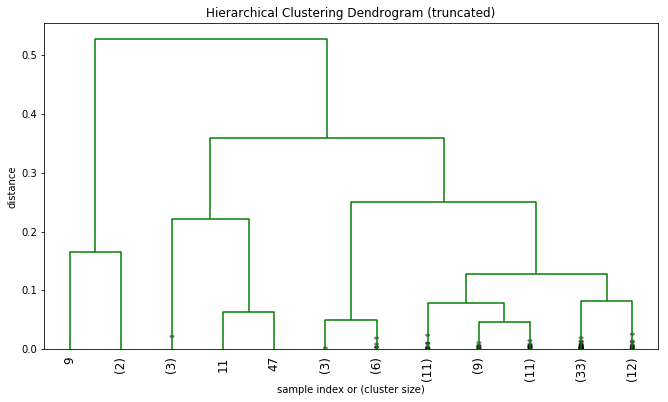

Euclidean Cophenetic Correlation Coefficient: 0.8651027032299118
Euclidean Clusters


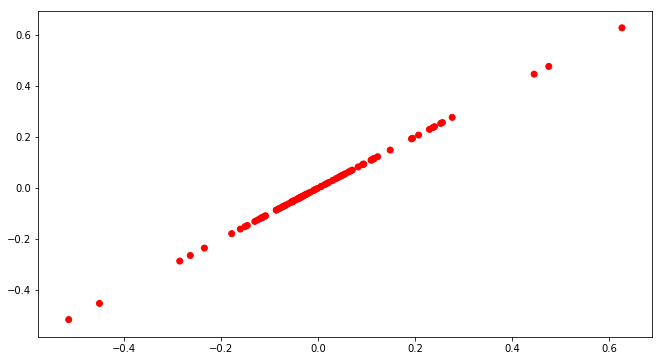

BTC_DASH
Minowski / Avg


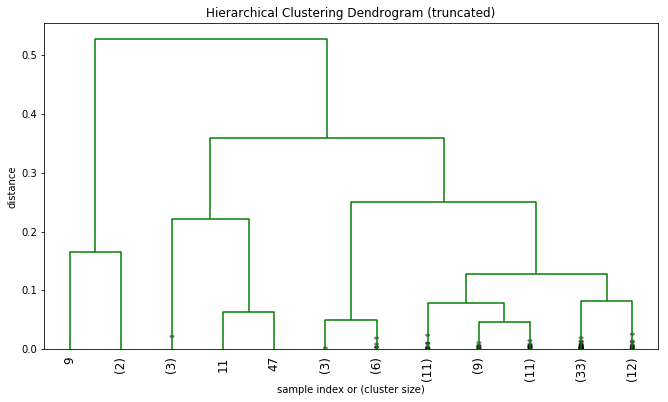

Minowski Cophenetic Correlation Coefficient: 0.8651027032299118
Euclidean Clusters


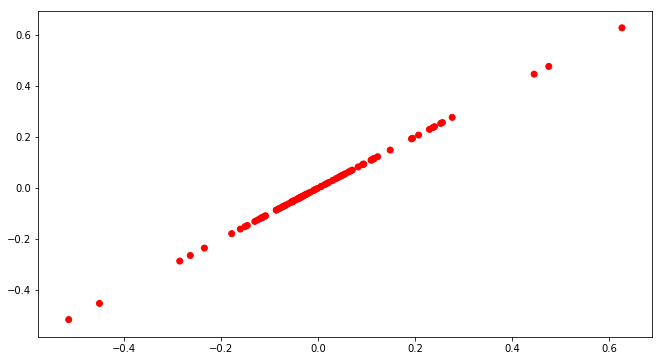

BTC_DASH
Cityblock / Avg


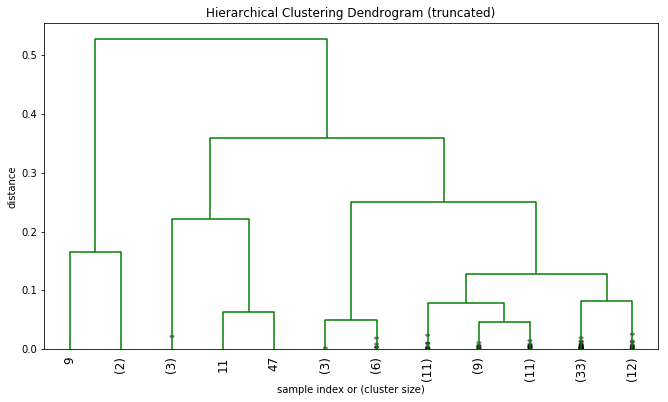

Cityblock Cophenetic Correlation Coefficient: 0.8651027032299118
Euclidean Clusters


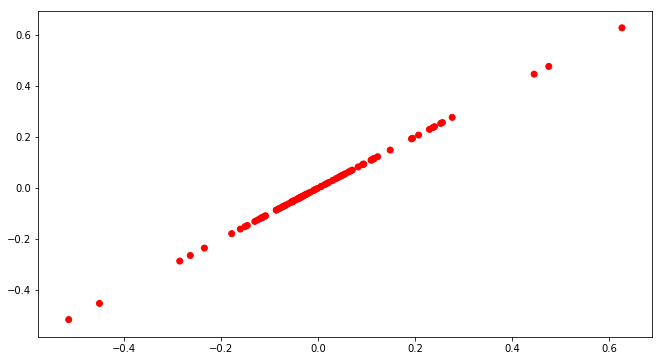

BTC_DASH
Cosine / Avg


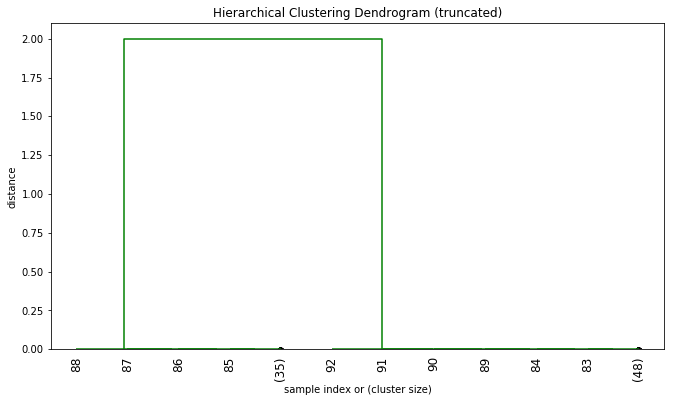

Cosine Cophenetic Correlation Coefficient: 0.3963988115459523
Euclidean Clusters


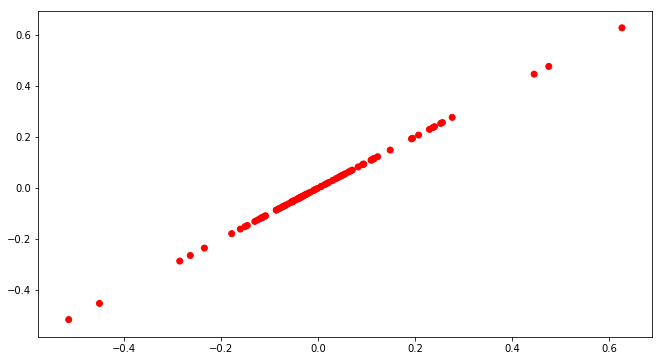

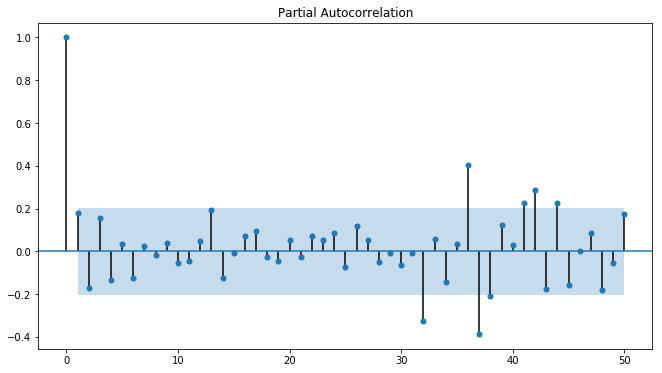

In [12]:
for series, pair in get_pairs():
    generate_clusters(series, pair)
    plot_partial_lag(series, 50)